# Miniproject 2: Chatbot

## Introduction

### Description

Developing a model employing ANN on real-world data requires going through several major steps, each of which with 
important design choices that directly impact the final results. 
In this project, we guide you through these choices starting from a large database of 
[conversations](http://parl.ai/downloads/personachat/personachat.tgz) to a functional chatbot. 

### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/).
- You should know the concepts "recurrent neural networks", "LSTM", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will be guided through a data processing procedure and understand the importance of design choices in ANN modeling
- You will learn how to define recurrent neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed in the lecture, like "overfitting", "LSTM network", and "Generative model".
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night and make sure you save (and load) your data and models.

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. 
We will only do random tests of your code and not re-run the full notebook. 
Please ensure that your notebook is fully executed before handing it in. 

### Submission 

You should submit your notebook through the Moodle page submission tool. You should work in teams of two people and each member should submit the same notebook to Moodle.



## Functions and imports

For your convenience we import some libraries and provide some functions below. Fill in your names, sciper numbers and run the following cell.

In [13]:
names = {'student_1': "Lucas Zweili",
        'student_2': "Raphaël Reis Nunes"}

sciper = {'student_1': 264542, 
          'student_2': 256364}

seed = sciper['student_1']+sciper['student_2']

%matplotlib inline

#GPU acceleration
from tensorflow.python.client import device_lib
from keras import backend as K
K.tensorflow_backend._get_available_gpus()
print(device_lib.list_local_devices())

import numpy as np
import matplotlib.pyplot as plt
import os, sys
import copy

plt.rcParams['font.size'] = 28
plt.style.use('ggplot')
plt.rcParams["axes.grid"] = False
c = plt.rcParams['axes.prop_cycle'].by_key()['color']

import keras
from keras.models import Model, load_model
from keras.layers import Input, Masking, Reshape, TimeDistributed, Dense, Flatten, Concatenate, Dropout, LSTM, CuDNNLSTM, GRU, CuDNNGRU, SimpleRNN, Bidirectional, Embedding, BatchNormalization
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint, EarlyStopping


def getRawDataFromFile(datapath="../../personachat/", file="train_both_revised.txt"):
    
    f = open(datapath+file)

    conversations = []
    current_conversation = []
    
    for l, line in enumerate(f):
        #print(l, line)
        if "persona:" in line:
            if len(current_conversation) > 1:
                conversations.append(current_conversation)
            current_conversation = [] 
            continue

        #remove numberings
        processed_line = line.split(' ')
        processed_line = " ".join(processed_line[1:])
        line = processed_line
        #print(line)

        conv = line.split('\t')    
        q = conv[0]
        a = conv[1]
        current_conversation.append(q)
        current_conversation.append(a)
    
    return conversations 

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2683787903114115005
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4844879872
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11780491255831966564
physical_device_desc: "device: 0, name: GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


## Data visualization and preprocessing

Here we will process and visualize the data.


### Parse raw data 

Download the dataset on http://parl.ai/downloads/personachat/personachat.tgz. Unpack it and add it to your project folder. Read and run the getRawDataFromFile function (if needed, modify the default path). It extracts the conversations.

**Output** Display two randomly selected conversations. [1 pt]

In [14]:
conv = getRawDataFromFile()

idx1, idx2 = np.random.choice(len(conv), 2)

conv[idx1], conv[idx2]

(['hey what are you up to ?',
  'hi ! i am having dinner . . . a slice of chocolate cake with extra vanilla cream',
  'sounds yummy ! watching a adventure action movie and eating some popcorn',
  'it is ! ! cake is the dinner part and the frosting is the extra sweet dessert .',
  'a sweet desert would be welding collar coasters as i love riding them !',
  'ahh , love coasters . i also love playing rock on my guitar . whats your job ?',
  'sweet tunes ! next week i am starting a gig for a construction site , you ?',
  'i am a police officer in michigan , a state trooper . watch out ! !',
  'thanks for serving our country , my moms been in the force',
  'an honor ! but i also have 2 siberians . those huskies are like a second job !',
  'beautiful ! i am my mothers second job ha , dad left when i was 5',
  'oh , so sorry . but she did a great job . i am a single mom too .'],
 ['hi there ! i love sewing . do you ?',
  'no no , hate it all',
  'fine ! i enjoy being alone with my cat on my l

### Extract word tokens

Let's start looking at our data. 

**Code** Compute the set of unique words (dictionary) in all sentences along with the number of occurences of each of these words. HINT: each word is separated by a space character, use the python string.split(' ') function to separate words. Consider punctuations as 'words'. [1 pt]

In [15]:
dico = {}

for c in conv:
    for s in c:
        words = s.split(" ")
        for w in words:
            if w in dico.keys():
                dico[w] += 1
            else:
                dico[w] = 1

sorted_list = sorted(dico.items(), key = lambda x: x[1], reverse=True)
# Display top 10 most frequent words used in these conversations.
print(sorted_list[:10])

[('i', 103476), ('.', 101587), ('you', 48295), ('?', 43768), (',', 39499), ('a', 34213), ('to', 32102), ('do', 30574), ('is', 28573), ('my', 26950)]


**Figure** In a bar plot, show the first 75 most frequent words (x-axis) and their number of occurences (y-axis). [1 pt]

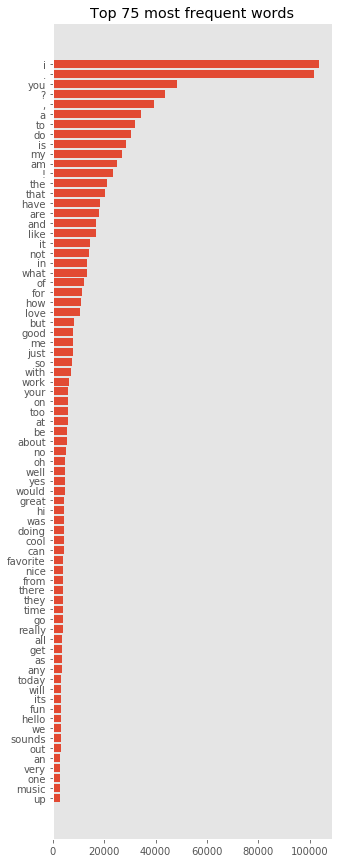

In [16]:
plt.figure(figsize=(5,15))
x = np.arange(75)
labels = [elem[0] for elem in sorted_list[:75][::-1]]
heights = [elem[1] for elem in sorted_list[:75][::-1]]
bars = plt.barh(x, heights)

plt.yticks(x, labels)
plt.title("Top 75 most frequent words")
plt.show()

**Figure** In another bar plot, show the 75 least frequent words (x-axis) and their number of occurences (y-axis). [1 pt] 

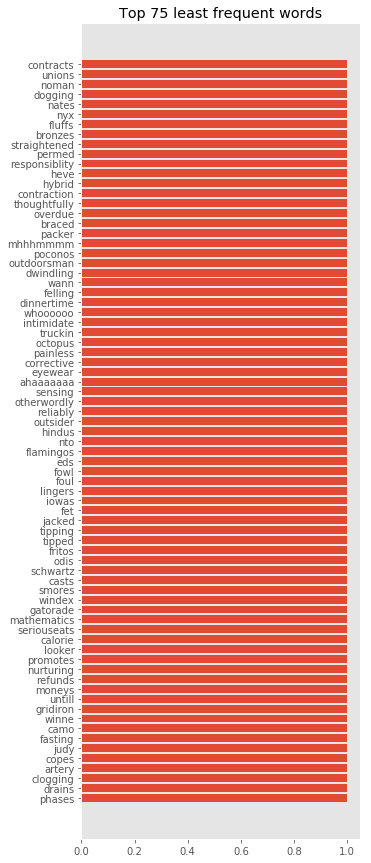

In [17]:
plt.figure(figsize=(5,15))
x = np.arange(75)
labels = [elem[0] for elem in sorted_list[-75:][::-1]]
heights = [elem[1] for elem in sorted_list[-75:][::-1]]
bars = plt.barh(x, heights)

plt.yticks(x, labels)
plt.title("Top 75 least frequent words")
plt.show()

**Figure** In a log-log scale, plot the sorted word index (x-axis) vs their respective count (y-axis). [1 pt]

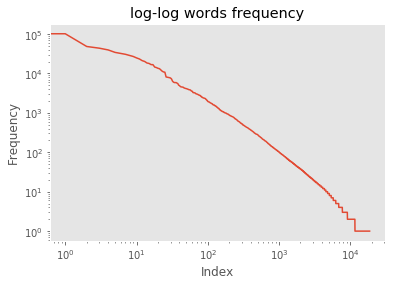

In [18]:
x = np.arange(len(dico))
heights = [elem[1] for elem in sorted_list]
plt.loglog(x, heights)

plt.title("log-log words frequency")
plt.ylabel("Frequency")
plt.xlabel("Index")
plt.show()

**Question** Relate the sorted word count distribution with Zipf's law.
Argue using the log-log plot. [1 pt]

**Answer**

**the Zip's law states that the frequency is inversely proportional to the rank or index in our sorted_list. So the most frequent word should be 2 times more frequent than the second one and three times more than the third word and so on.  This could be verify by the linearity of the log-log plot. Which implies that the word count distribution follows the zipf's law**

**Question** How many words appear only once in the entire dataset? [1 pt]

**Answer**

In [19]:
#Get the length of the filtered dictionary (where frequency of the word == 1)
num_word_1 = len({k: v for k,v in dico.items() if v == 1})
num_word_tot = len(dico)
"{un} / {tot} words appearing only once".format(un=num_word_1, tot=num_word_tot)

'7080 / 18673 words appearing only once'

### Filtering

We suggest to filter your data by removing sentences containing rare words. 


**Code** To achieve that, you should create a new dataset where sentences containing rare words (words that occur less than N times in the dataset) are removed. Keep at least 50'000 sentences (depending on your computing power, you can keep more). 
HINT: Start by updating the dictionary accordingly and then remove any sentence that contains at least a single word that is not in the dictionary of words. [2 pts]

In [20]:
# if a word occur less than n times, we remove the sentence of the conversations.

n = 20
norare_dico = {k: v for k,v in dico.items() if v > n}
norare_conv = copy.deepcopy(conv)

for i,c in enumerate(conv):
    for s in c:
        words = s.split(" ")
        for w in words:
            if s not in norare_conv[i]:
                break
            else:
                if w not in norare_dico.keys():
                    norare_conv[i].remove(s)


**Question**: How much did you reduce the number of unique words with your rare event suppression procedure? [1 pt]
    
**Answer**: 

In [58]:
print(len(dico)-len(norare_dico),"/",len(dico), "words removed")

15707 / 18673 words removed


**Question**: How many sentences are in your filtered and original dataset? [1 pt]

**Answer**:

In [59]:
num_s_conv = len([x for y in conv for x in y])
num_s_norare_conv = len([x for y in norare_conv for x in y])

print("{f} sentences in our filtered dataset versus {n} sentences in original dataset".format(f=num_s_norare_conv, n=num_s_conv))

88100 sentences in our filtered dataset versus 131424 sentences in original dataset


**Question**: What is the impact on learning and generalization of removing sentences with rare words from your dataset? [2 pt]

**Answer**: 

**pros: we removed outliers so the models will be more generalized with less overfitting**

**cons: we have less samples on which we could train our models and thus losing some improvements.**

### Tokenization and padding

Now you will transform our filtered data into a format that is understandable by an ANN. To achieve that, you should transform words to integers, where single integers in the range [1,size of the dictionary] are mapped to single words in your dictionary. This process is commonly named 'tokenization'. In addition, we will keep the value 0 to a specific artificial word 'PADD' that will be used to account for the variable length of sentences and add to each sentence a 'START' and an 'END' word. 

**Code** Start by adding the three artificial words to your dictionary (list of possible tokens) and then translate every sentences to a list of integers. 
HINT: use the Python List index() method. [2 pts]

**Figure** Use the violinplot to show the density of tokenized sentences length. [1pt]

**Code** From this figure, select a maximum number (=maxlen) of tokens for which most of the sentences have less. Padd (and eventually truncate) all sentences with the 'PADD' token (value 0 in the integer representation) until all tokenized sentences have the same length (maxlen).
HINT: use the pad_sequences function from keras.preprocessing.sequence [2 pts]

**Code** Check that you can recover the original sentence. Randomly select two sentences from your integer and padded representation and translate them back using your dictionary. [1 pt]

In [60]:
tokens = copy.deepcopy(norare_dico)


#Then tokenization of the dictionary
for i,w in enumerate(norare_dico,1):
    tokens[w] = i

# Add the 3 artifical words
tokens["PADD"] = 0
tokens["START"] = i + 1
tokens["STOP"] = i + 2

In [4]:
def translate(s, dico_to_token, to_token=True):
    new_s = []
    if to_token:
        for w in s:
            token = dico_to_token[w]
            new_s.append(token)
    else:
        
        inverted_dico = {token: word for word, token in dico_to_token.items()}
        
        for t in s:
            word = inverted_dico[t]
            if word in ["PADD","START","STOP"]:
                continue
            else:
                new_s.append(word)

    return new_s

In [62]:
#Translate sentences to list of integers
translate_conv = copy.deepcopy(norare_conv)

for i,c in enumerate(norare_conv):
    for j,s in enumerate(c):
        
        words = s.split(" ")
        new_s = translate(words,tokens,to_token=True)
            
        # Add to every sentences START and STOP tokens
        new_s = [tokens["START"]] + new_s
        new_s.append(tokens["STOP"])
        
        translate_conv[i][j] = new_s

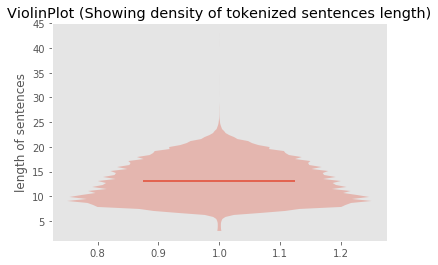

In [63]:
data = [len(s) for c in translate_conv for s in c]

plt.violinplot(data,showmedians=True, showextrema=False)
plt.ylabel("length of sentences")
plt.title("ViolinPlot (Showing density of tokenized sentences length)")
plt.show()

In [64]:
# As, we can see on the violinPlot above, most of the sentences have less than 25 words.
maxlen = 25
padded_conv = copy.deepcopy(translate_conv)
for i,c in enumerate(translate_conv):
    padded = pad_sequences(c, maxlen = maxlen, dtype = "uint32", padding = "post", truncating = "post", value = 0)
    padded_conv[i] = padded

In [67]:
# Translate back 2 random sentences from padded_conv
padded_s = [s for c in padded_conv for s in c]
idx1, idx2 = np.random.choice(range(len(padded_s)), 2)

translate(padded_s[idx1],tokens,to_token=False), translate(padded_s[idx2],tokens,to_token=False)

(['great', '!', 'are', 'you', 'married', '?', 'any', 'kids', '?'],
 ['do', 'you', 'play', 'any', 'music', '?'])

In [68]:
padded_s[idx1]

array([2967,  143,   31,    4,    5,  521,    7,   64,  227,    7, 2968,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0], dtype=uint32)

### Saving

Now is a good time to save your data (end of processing). An example code using the pickle library is shown below.


In [2]:
import pickle

In [70]:
#save
with open("data.pkl", "wb") as file:
    pickle.dump([padded_conv, norare_dico, tokens], file)
    

In [3]:
#load
with open("data.pkl", "rb") as file:
    [filtered_sentences, dictionary, tokens] = pickle.load(file)

## Building and training generative models of language

### RNN vs LSTM vs GRU 

Build, train and compare generative models of language based on RNNs with different recurrent units (SimpleRNN, GRU and LSTM). 

The target of the network will be to approximate the word transition probabilities Pr(word[n+1]|H[n]) with H[n]=f(word[:n]) being the hidden state of the network.  

**code** You should complete the proposed model (using the Keras API rather than the Sequential model for more flexibility). Be sure to understand each line. The embedding layer allows to transform an integer to a dense vector. That would be our input to the recurrent network - each sentence is mapped to a sequence of vectors, each representing a single word. You can then design your own readout(s) and output layers. By default, use the proposed meta parameters. You can adapt them if you have more or less computing power (32 epochs should take around 30 minutes). [2 pts]

**Question** How will your networks deal with the artificial word 'PADD' that you added at the end of each sentences  [2 pts]

**Answer**: **It will always predict a "PADD" word after it.

**code** Then train three different networks with the same architecture but using different recurrent units (simpleRNN, GRU and LSTM). Save the learning history (training/validation loss and accuracy for each epoch) as well as the models. [1 pt]

**Question** How can you use this network to approximate the word transition probabilities? What will be the inputs and targets of the network at each batch? Give the input/output tensor dimensions. [2 pts]

**Answer**: **input shape (#sentences,maxlen-1,1) and output shape (#sentences,maxlen-1,vocabulary size). Input is the tokenized list of sentences and output gives for each sentence and each word position the probability vector of vocabulary size.**

**Figure** Show the learning curves (training and validation loss) for the different recurrent units. [1 pt] **see below**

**Figure** Show the learning curves (training and validation accuracy) for the different recurrent units. [1 pt] **see below**

**Question:** Which recurrent unit yields the best validation accuracy? Which is the fastest learner? [1 pt]

**Answer**: **LSTM unit is yielding the best validation accuracy with 0.4039 versus 0.3987 and 0.4039 for SimpleRNN and GRU, respectively. Fastest learner is the GRU unit with an average of 150s per epochs versus 200s and 210s for SimpleRNN and LSTM, respectively.**

**Question:** Do you observe an overfitting effect? Where and for which case? Give a possible explanation. [1 pt] 

**Answer**: **Yes for the 3 units. Maybe the model is too complex (too many hidden neurons).**

**Question:** Suggest one option modifying your dataset to decrease overfitting. [1 pt]

**Answer**: **We could increase the total number of unique words, making the dataset more complex to learn**

**Question:** Suggest one possible option modifying your network to decrease overfitting. [1 pt]

**Answer**: **We could decrease the number of hidden neurons, reducing the complexity of the model.**

**Question:** Suggest one possible option modifying the training modalities to counter overfitting. [1 pt]   

**Answer**: **We could increase the dropout probability of the recurrent layer, making the models more robust to new samples, thus decreasing overfitting. Or reducing the training duration by decreasing the number of epochs with Earlstopping.**

In [59]:
#Meta-parameters
embedding_size = 128
hidden_size = 64
dropout = 0.
recurrent_dropout = 0.

batch_size = 64
epochs = 32
validation_split = 0.2

dataset_cut = -1
maxlen = 25

In [5]:
I = {}
E = {}
H = {}
R = {}
Y = {}
models = {}
logs = {}

In [6]:
#reshape dataset and target for RNN
list_sentences = [s for c in filtered_sentences for s in c]
X = np.array(list_sentences.copy())

#one hot encoding of X for target T
T = keras.utils.to_categorical(np.asarray(X))

In [205]:
X[0,:],T[0,:]

(array([2967,    5,   20,   21,   22,   23,   19,   24,   25,   26,   27,
          28,   29,   30,   19, 2968,    0,    0,    0,    0,    0,    0,
           0,    0,    0], dtype=uint32), array([[0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]], dtype=float32))

In [9]:
#Model suggestion

I['RNN'] = Input(shape=(maxlen-1,), name="input")
E['RNN'] = Embedding(len(tokens), embedding_size, mask_zero=True, input_length=24, name="embedding")(I['RNN'])

#your network here
H['RNN'] = SimpleRNN(hidden_size,activation='relu', dropout=dropout, recurrent_dropout=recurrent_dropout, unroll=True, return_sequences=True)(E['RNN'])

R['RNN'] = TimeDistributed(Dense(embedding_size, activation="relu"), name='readout')(H["RNN"])

Y['RNN'] = TimeDistributed(Dense(len(tokens), activation="softmax"), name='output')(R['RNN'])


models['RNN'] = Model(inputs = [I['RNN']], outputs = [Y['RNN']])
models['RNN'].compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(),
    metrics=['acc'])
models['RNN'].summary()

print(X[:,:-1].shape, T[:,1:].shape)
logs['RNN'] = models['RNN'].fit({'input': X[:dataset_cut,:-1]}, {'output': T[:dataset_cut,1:]}, 
                                    epochs=epochs, 
                                    validation_split=validation_split, 
                                    batch_size=batch_size).history

#save
with open("RNNmodel_"+str(embedding_size)+'_'+str(hidden_size)+"_log.pkl", "wb") as file:
    pickle.dump(logs['RNN'], file)
models['RNN'].save("RNNmodel_"+str(embedding_size)+'_'+str(hidden_size))

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 24)                0         
_________________________________________________________________
embedding (Embedding)        (None, 24, 128)           380032    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 24, 64)            12352     
_________________________________________________________________
readout (TimeDistributed)    (None, 24, 128)           8320      
_________________________________________________________________
output (TimeDistributed)     (None, 24, 2969)          383001    
Total params: 783,705
Trainable params: 783,705
Non-trainable params: 0
_________________________________________________________________
(88100, 24) (88100, 24, 2969)
Instructions for updating:
Use tf.

In [21]:
#load
with open("RNNmodel_"+str(embedding_size)+'_'+str(hidden_size)+"_log.pkl", "rb") as file:
    RNNmodel_log = pickle.load(file)
RNNmodel = load_model("RNNmodel_"+str(embedding_size)+'_'+str(hidden_size))

Instructions for updating:
Use tf.cast instead.


In [10]:
#Model suggestion

I['LSTM'] = Input(shape=(maxlen-1,), name="input")
E['LSTM'] = Embedding(len(tokens), embedding_size, mask_zero=True, name="embedding")(I['LSTM'])

#your network here
H['LSTM'] = LSTM(hidden_size, activation='relu', dropout=dropout, recurrent_dropout=recurrent_dropout, unroll=True, return_sequences=True)(E['LSTM'])
#H['LSTM'] = CuDNNLSTM(hidden_size)(E['LSTM'])

R['LSTM'] = TimeDistributed(Dense(embedding_size, activation="relu"), name='readout')(H["LSTM"])

Y['LSTM'] = TimeDistributed(Dense(len(tokens), activation="softmax"), name='output')(R['LSTM'])

models['LSTM'] = Model(inputs = [I['LSTM']], outputs = [Y['LSTM']])
models['LSTM'].compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(),
    metrics=['acc'])
models['LSTM'].summary()

print(X[:,:-1].shape, T[:,1:].shape)
logs['LSTM'] = models['LSTM'].fit({'input': X[:dataset_cut,:-1]}, {'output': T[:dataset_cut,1:]}, 
                                    epochs=epochs, 
                                    validation_split=validation_split, 
                                    batch_size=batch_size).history

#save
with open("LSTMmodel_"+str(embedding_size)+'_'+str(hidden_size)+"_log.pkl", "wb") as file:
    pickle.dump(logs['LSTM'], file)
models['LSTM'].save("LSTMmodel_"+str(embedding_size)+'_'+str(hidden_size))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 24)                0         
_________________________________________________________________
embedding (Embedding)        (None, 24, 128)           380032    
_________________________________________________________________
lstm_1 (LSTM)                (None, 24, 64)            49408     
_________________________________________________________________
readout (TimeDistributed)    (None, 24, 128)           8320      
_________________________________________________________________
output (TimeDistributed)     (None, 24, 2969)          383001    
Total params: 820,761
Trainable params: 820,761
Non-trainable params: 0
_________________________________________________________________
(88100, 24) (88100, 24, 2969)
Train on 70479 samples, validate on 17620 samples
Epoch 1/32
70479/70479 [==============================] 

In [174]:
#Model suggestion

I['GRU'] = Input(shape=(maxlen-1,), name="input")
E['GRU'] = Embedding(len(tokens), embedding_size, mask_zero=True, name="embedding")(I['GRU'])

#your network here
H['GRU'] = GRU(hidden_size, activation='relu', dropout=dropout, recurrent_dropout=recurrent_dropout, unroll=True, return_sequences=True)(E['GRU'])
#H['GRU'] = CuDNNGRU(hidden_size)(E['GRU'])

R['GRU'] = TimeDistributed(Dense(embedding_size, activation="relu"), name='readout')(H["GRU"])

Y['GRU'] = TimeDistributed(Dense(len(tokens), activation="softmax"), name='output')(R['GRU'])


models['GRU'] = Model(inputs = [I['GRU']], outputs = [Y['GRU']])
models['GRU'].compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(),
    metrics=['acc'])
models['GRU'].summary()

print(X[:,:-1].shape, T[:,1:].shape)
logs['GRU'] = models['GRU'].fit({'input': X[:dataset_cut,:-1]}, {'output': T[:dataset_cut,1:]}, 
                                    epochs=epochs, 
                                    validation_split=validation_split, 
                                    batch_size=batch_size).history

#save
with open("GRUmodel_"+str(embedding_size)+'_'+str(hidden_size)+"_log.pkl", "wb") as file:
    pickle.dump(logs['GRU'], file)
models['GRU'].save("GRUmodel_"+str(embedding_size)+'_'+str(hidden_size))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 24)                0         
_________________________________________________________________
embedding (Embedding)        (None, 24, 128)           380032    
_________________________________________________________________
gru_5 (GRU)                  (None, 24, 64)            37056     
_________________________________________________________________
readout (TimeDistributed)    (None, 24, 128)           8320      
_________________________________________________________________
output (TimeDistributed)     (None, 24, 2969)          383001    
Total params: 808,409
Trainable params: 808,409
Non-trainable params: 0
_________________________________________________________________
(88100, 24) (88100, 24, 2969)
Train on 70479 samples, validate on 17620 samples
Epoch 1/32
70479/70479 [==============================] 

In [175]:
with open("RNNmodel_128_64_log.pkl", "rb") as file:
    logs["RNN"] = pickle.load(file)

with open("LSTMmodel_128_64_log.pkl", "rb") as file:
     logs["LSTM"] = pickle.load(file)

with open("GRUmodel_128_64_log.pkl", "rb") as file:
    logs["GRU"] = pickle.load(file)

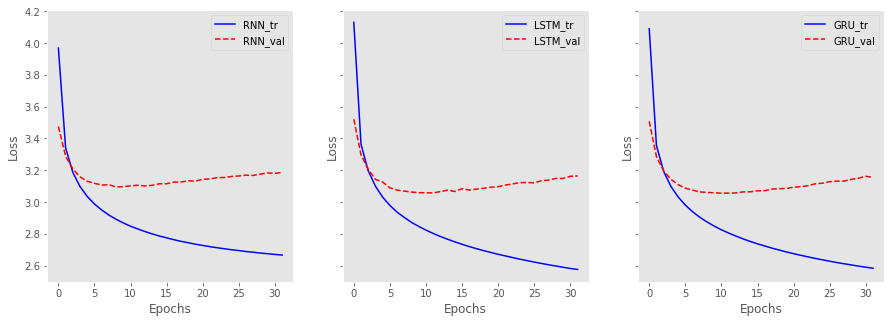

In [176]:
r_units = ["RNN", "LSTM", "GRU"]


f, ax = plt.subplots(1,3, sharey=True, figsize=(15,5))

for i,r_unit in enumerate(r_units):
    
    ax[i].plot(logs[r_unit]["loss"],label=r_unit + "_tr", color='blue')
    ax[i].plot(logs[r_unit]["val_loss"], ls="dashed", label=r_unit + "_val", color="red")
    ax[i].set_ylabel("Loss")
    ax[i].set_xlabel("Epochs")
    ax[i].legend()

plt.show()

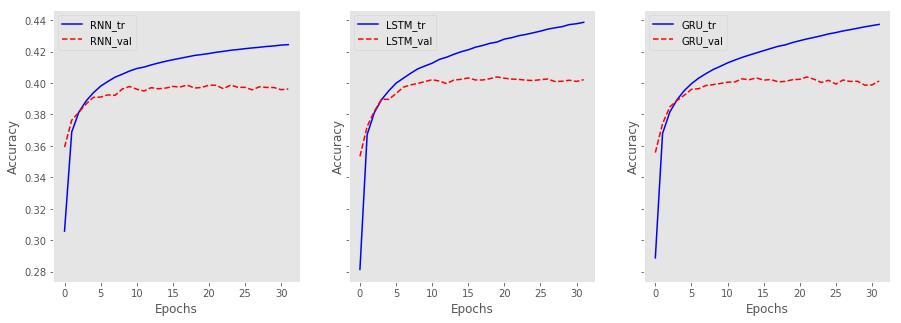

In [177]:
r_units = ["RNN", "LSTM", "GRU"]

f, ax = plt.subplots(1,3, sharey=True, figsize=(15,5))

for i,r_unit in enumerate(r_units):
    
    ax[i].plot(logs[r_unit]["acc"],label=r_unit + "_tr", color='blue')
    ax[i].plot(logs[r_unit]["val_acc"], ls="dashed", label=r_unit + "_val", color="red")
    ax[i].set_ylabel("Accuracy")
    ax[i].set_xlabel("Epochs")
    ax[i].legend()

plt.show()

In [178]:
print("yielded accuracy:")

for r_unit in r_units:
    
    print(r_unit, np.max(logs[r_unit]["val_acc"]))

yielded accuracy:
RNN 0.3987243720134731
LSTM 0.4039141099244593
GRU 0.40385260025840614


### Optimal network size

Compare the learning curves for three networks with 64 (previous exercise), 128 and 256 GRUs (single layer) and one with two hidden layers of 64 GRUs. 

**Code** Build and train the networks. Apply EarlyStopping (monitor='val_acc', min_delta=0.001, patience=2). Use transfer learning, do not train from scratch your embedding layer, rather re-use the embedding layer from your best performing network in the last exercise. [4 pts]

**Figure** Show the learning curves (training and validation loss) for the four models. [1 pt] **see below**

**Figure** Show the learning curves (training and validation accuracy) for the four models. [1 pt] **see below**

**Question** List and briefly explain the differences in the learning curves for the different models? [2 pts]

**Answer**: **for All models the train curves get better results, for the 2 first epochs, than the validation curve. After the 2nd epoch this is reverted, models are starting to overfit. The 64 model has the worse performance with only 0.4039 of validation accuracy and a lot of overfitting while the others are above 0.65 with less overfitting. The 128 model is performing slighty better than the 64_64 model and the 256 is even better but it has a bit more overfitting..
Performance: 64 < 64_64 < 128 < 256 \\
overfitting: 64 > 256 < 128 < 64_64 \\
train speed: 64 > 64_64 = 256 > 128**

**Question** What effect had EarlyStopping? Give one advantage and one drawback. [2 pts]

**Answer**: **It avoids overfitting and improves the generalization of the model as well as avoid spending too much time doing useless training. but if stopped too early the model won't learn the patterns**

**Question** What is your best model? Why? [1 pt]

**Answer**: **The 128 model is the best because it yields a really good perfomance with low overfitting and is the fastest model to train**



In [60]:
#load the best model LSTM
LSTM = load_model("LSTMmodel_"+str(embedding_size)+'_'+str(hidden_size))

In [33]:
#Using the embedding layer of the best performing network of previous exercice. (E["LSTM"])

lstm_embedding = LSTM.layers[1].get_weights()[0]
from keras.initializers import Constant

#Earlystopping criteria
callback = EarlyStopping(monitor='val_acc', min_delta=0.001, patience=2)

In [10]:
#Model suggestion
hidden_size = 128

I['GRU_128'] = Input(shape=(maxlen-1,), name="input")

E['GRU_128'] = Embedding(len(tokens), embedding_size, embeddings_initializer=Constant(lstm_embedding),
                            trainable=False)(I['GRU_128'])

#your network here
H['GRU_128'] = GRU(hidden_size, activation='relu', dropout=dropout, recurrent_dropout=recurrent_dropout, unroll=True, return_sequences=True)(E['GRU_128'])
#H['GRU'] = CuDNNGRU(hidden_size)(E['GRU'])

R['GRU_128'] = TimeDistributed(Dense(embedding_size, activation="relu"), name='readout')(H["GRU_128"])

Y['GRU_128'] = TimeDistributed(Dense(len(tokens), activation="softmax"), name='output')(R['GRU_128'])

models['GRU_128'] = Model(inputs = [I['GRU_128']], outputs = [Y['GRU_128']])
models['GRU_128'].compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(),
    metrics=['acc'])
models['GRU_128'].summary()

print(X[:,:-1].shape, T[:,1:].shape)
logs['GRU_128'] = models['GRU_128'].fit({'input': X[:dataset_cut,:-1]}, {'output': T[:dataset_cut,1:]}, 
                                    epochs=epochs, 
                                    validation_split=validation_split, 
                                    batch_size=batch_size,
                                    callbacks = [callback]).history

#save
with open("GRUmodel_"+str(embedding_size)+'_'+str(hidden_size)+"_log.pkl", "wb") as file:
    pickle.dump(logs['GRU_128'], file)
models['GRU_128'].save("GRUmodel_"+str(embedding_size)+'_'+str(hidden_size))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 24)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 24, 128)           380032    
_________________________________________________________________
gru_1 (GRU)                  (None, 24, 128)           98688     
_________________________________________________________________
readout (TimeDistributed)    (None, 24, 128)           16512     
_________________________________________________________________
output (TimeDistributed)     (None, 24, 2969)          383001    
Total params: 878,233
Trainable params: 498,201
Non-trainable params: 380,032
_________________________________________________________________
(88100, 24) (88100, 24, 2969)
Train on 70479 samples, validate on 17620 samples
Epoch 1/32
70479/70479 [==========================

In [11]:
hidden_size = 256

I['GRU_256'] = Input(shape=(maxlen-1,), name="input")

#Using the embedding layer of the best performing network of previous exercice. (E["LSTM"])
E['GRU_256'] = Embedding(len(tokens), embedding_size, embeddings_initializer=Constant(lstm_embedding),
                            input_length=24,
                            trainable=False)(I['GRU_256'])

#your network here
H['GRU_256'] = GRU(hidden_size, activation='relu', dropout=dropout, recurrent_dropout=recurrent_dropout, unroll=True, return_sequences=True)(E['GRU_256'])
#H['GRU'] = CuDNNGRU(hidden_size)(E['GRU'])

R['GRU_256'] = TimeDistributed(Dense(embedding_size, activation="relu"), name='readout')(H["GRU_256"])

Y['GRU_256'] = TimeDistributed(Dense(len(tokens), activation="softmax"), name='output')(R['GRU_256'])

models['GRU_256'] = Model(inputs = [I['GRU_256']], outputs = [Y['GRU_256']])
models['GRU_256'].compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(),
    metrics=['acc'])
models['GRU_256'].summary()

print(X[:,:-1].shape, T[:,1:].shape)
logs['GRU_256'] = models['GRU_256'].fit({'input': X[:dataset_cut,:-1]}, {'output': T[:dataset_cut,1:]}, 
                                    epochs=epochs, 
                                    validation_split=validation_split, 
                                    batch_size=batch_size,
                                    callbacks = [callback]).history

#save
with open("GRUmodel_"+str(embedding_size)+'_'+str(hidden_size)+"_log.pkl", "wb") as file:
    pickle.dump(logs['GRU_256'], file)
models['GRU_256'].save("GRUmodel_"+str(embedding_size)+'_'+str(hidden_size))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 24)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 24, 128)           380032    
_________________________________________________________________
gru_2 (GRU)                  (None, 24, 256)           295680    
_________________________________________________________________
readout (TimeDistributed)    (None, 24, 128)           32896     
_________________________________________________________________
output (TimeDistributed)     (None, 24, 2969)          383001    
Total params: 1,091,609
Trainable params: 711,577
Non-trainable params: 380,032
_________________________________________________________________
(88100, 24) (88100, 24, 2969)
Train on 70479 samples, validate on 17620 samples
Epoch 1/32
70479/70479 [========================

In [9]:
hidden_size = 64
H2 = {}

I['GRU_64_64'] = Input(shape=(maxlen-1,), name="input")

#Using the embedding layer of the best performing network of previous exercice. (E["LSTM"])
E['GRU_64_64'] = Embedding(len(tokens), embedding_size, embeddings_initializer=Constant(lstm_embedding),
                            input_length=24,
                            trainable=False)(I['GRU_64_64'])

#your network here
H['GRU_64_64'] = GRU(hidden_size, activation='relu', dropout=dropout,
                     recurrent_dropout=recurrent_dropout, unroll=True,
                     return_sequences=True)(E['GRU_64_64'])
H2['GRU_64_64'] = GRU(hidden_size, activation='relu', dropout=dropout,
                      recurrent_dropout=recurrent_dropout, unroll=True,
                     return_sequences=True)(H['GRU_64_64'])


R['GRU_64_64'] = TimeDistributed(Dense(embedding_size, activation="relu"), name='readout')(H["GRU_64_64"])

Y['GRU_64_64'] = TimeDistributed(Dense(len(tokens), activation="softmax"), name='output')(R['GRU_64_64'])

models['GRU_64_64'] = Model(inputs = [I['GRU_64_64']], outputs = [Y['GRU_64_64']])
models['GRU_64_64'].compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(),
    metrics=['acc'])
models['GRU_64_64'].summary()

print(X[:,:-1].shape, T[:,1:].shape)
logs['GRU_64_64'] = models['GRU_64_64'].fit({'input': X[:dataset_cut,:-1]}, {'output': T[:dataset_cut,1:]}, 
                                    epochs=epochs, 
                                    validation_split=validation_split, 
                                    batch_size=batch_size,
                                    callbacks = [callback]).history

#save
with open("GRUmodel_"+str(embedding_size)+'_'+str(hidden_size)+'_'+str(hidden_size)+"_log.pkl", "wb") as file:
    pickle.dump(logs['GRU_64_64'], file)
models['GRU_64_64'].save("GRUmodel_"+str(embedding_size)+'_'+str(hidden_size)+'_'+str(hidden_size))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 24)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 24, 128)           380032    
_________________________________________________________________
gru_1 (GRU)                  (None, 24, 64)            37056     
_________________________________________________________________
readout (TimeDistributed)    (None, 24, 128)           8320      
_________________________________________________________________
output (TimeDistributed)     (None, 24, 2969)          383001    
Total params: 808,409
Trainable params: 428,377
Non-trainable params: 380,032
_________________________________________________________________
(88100, 24) (88100, 24, 2969)
Train on 70479 samples, validate on 17620 samples
Epoch 1/32
70479/70479 [==========================

In [179]:
#load 
with open("GRUmodel_128_64_log.pkl", "rb") as file:
    logs["GRU"] = pickle.load(file)

with open("GRUmodel_128_128_log.pkl", "rb") as file:
     logs["GRU_128"] = pickle.load(file)

with open("GRUmodel_128_256_log.pkl", "rb") as file:
    logs["GRU_256"] = pickle.load(file)

with open("GRUmodel_128_64_64_log.pkl", "rb") as file:
    logs["GRU_64_64"] = pickle.load(file)
    

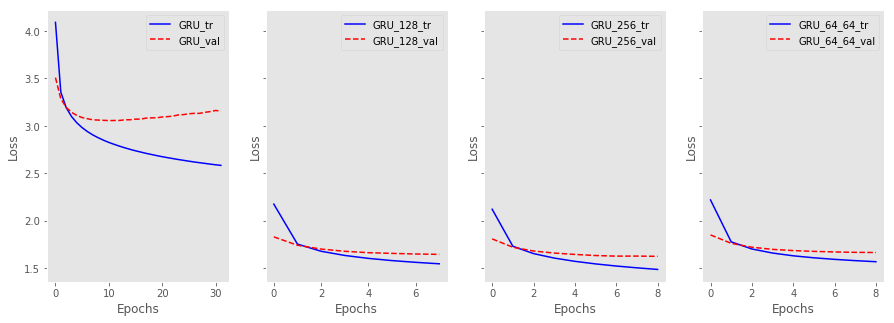

In [180]:
r_units = ["GRU","GRU_128", "GRU_256", "GRU_64_64"]


f, ax = plt.subplots(1,4, sharey=True, figsize=(15,5))

for i,r_unit in enumerate(r_units):
    
    ax[i].plot(logs[r_unit]["loss"],label=r_unit + "_tr", color='blue')
    ax[i].plot(logs[r_unit]["val_loss"], ls="dashed", label=r_unit + "_val", color="red")
    ax[i].set_ylabel("Loss")
    ax[i].set_xlabel("Epochs")
    ax[i].legend()

plt.show()

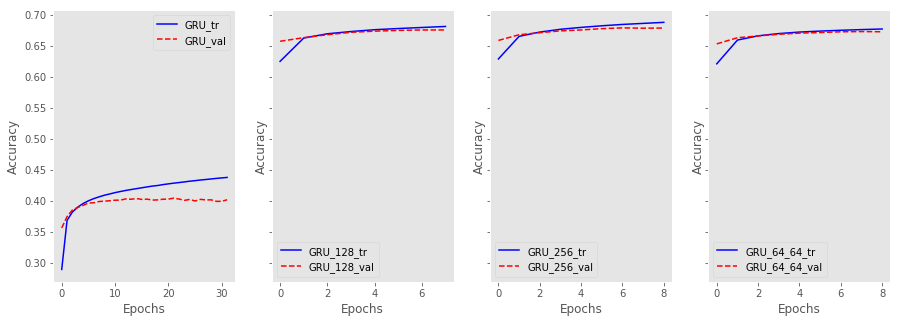

In [181]:
r_units = ["GRU","GRU_128", "GRU_256", "GRU_64_64"]

f, ax = plt.subplots(1,4, sharey=True, figsize=(15,5))

for i,r_unit in enumerate(r_units):
    
    ax[i].plot(logs[r_unit]["acc"],label=r_unit + "_tr", color='blue')
    ax[i].plot(logs[r_unit]["val_acc"], ls="dashed", label=r_unit + "_val", color="red")
    ax[i].set_ylabel("Accuracy")
    ax[i].set_xlabel("Epochs")
    ax[i].legend()

plt.show()

### Generate sentences

Now you will generate new sentences from your best performing model.

**Code** To achieve that, use the provided sample function below to generate new sentences from your model. You should start by constructing a sentence that starts with the 'START' artificial word and all other words being the 'PADD' artificial word. Then sample the first word from the corresponding probabilities given by your model. Add this word to the sentence and continue like this until you sample the 'END' artificial word or the maximum sentence length. [2 pts]

**Code** Generate 10 sentences for different sampling temperature in [0., 0.25, 0.5, 0.75, 1., 1.5., 2.]. [1 pt]

**7 Figures** For each temperature, use matplotlib imshow to plot the probablities of every word in one generated sentence (and only these words) at each time step. y-axis should be the words that are present in the sentence. x-axis the timesteps and the imshow value the probabilities given by the model for all words in the sentence at each timestep. Use the a colormap where 0 is white, e.g. cmap='Greys'. [2 pts] **see below**

**Code** Finally, seed your model with two different beginnings of max 4 words and let it generate 10 possible continuations (use sampling temperature of 1.). [2 pts]

**Question** What is the effect of sampling temperature on the generated sentences? [1 pt]

**Answer**: **the higher the temperature is the more uniform is the probability distribution. thus increasing diversity in the sentence. The lower the temperature is the larger the differences between probability will be. thus decreasing diversity in the sentence.**

**Question** In terms of sampling a probability distribution, what does a sampling temperature of 0 corresponds to? [1 pt] 

**Answer**: **Taking only the word that has the highest probability. --> no diversity.**

**Question** In terms of sampling a probability distribution, what does a sampling temperature of 1. corresponds to? [1 pt] 

**Answer**: **Applying normalization to the output probability distribution and the next word is chosen proportionally to its probability (e.g. word proba 0.8 --> chosen 8/10 and 2/10 another word instead)**

**Question** In terms of sampling a probability distribution, what does a very high sampling temperature corresponds to? [1 pt]

**Answer**: **Uniformization of the probability distribution --> random sentences.**

**Question** Based on the plotted word probabilities, explain how a sentence is generated. [2 pts]

**Answer**: **step after step or word after word the probability of the chosen words are building a momentum around the timestep that represents their position in the sentence. Based on the sample function, which changes its behavior in function of t, the word is chosen.**

**Question** Do you observe timesteps with more than one word with non-zero probability? How do these probable words relate in terms of language? [1 pt]

**Answer**: **yes, there are words that are part of the same family / context.**

In [7]:
def sample(preds, temperature=1.):
    # helper function to sample an index from a probability array
    if temperature == 0.:
        return np.argmax(preds)
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)


In [8]:
best_model = load_model("GRUmodel_128_128")

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


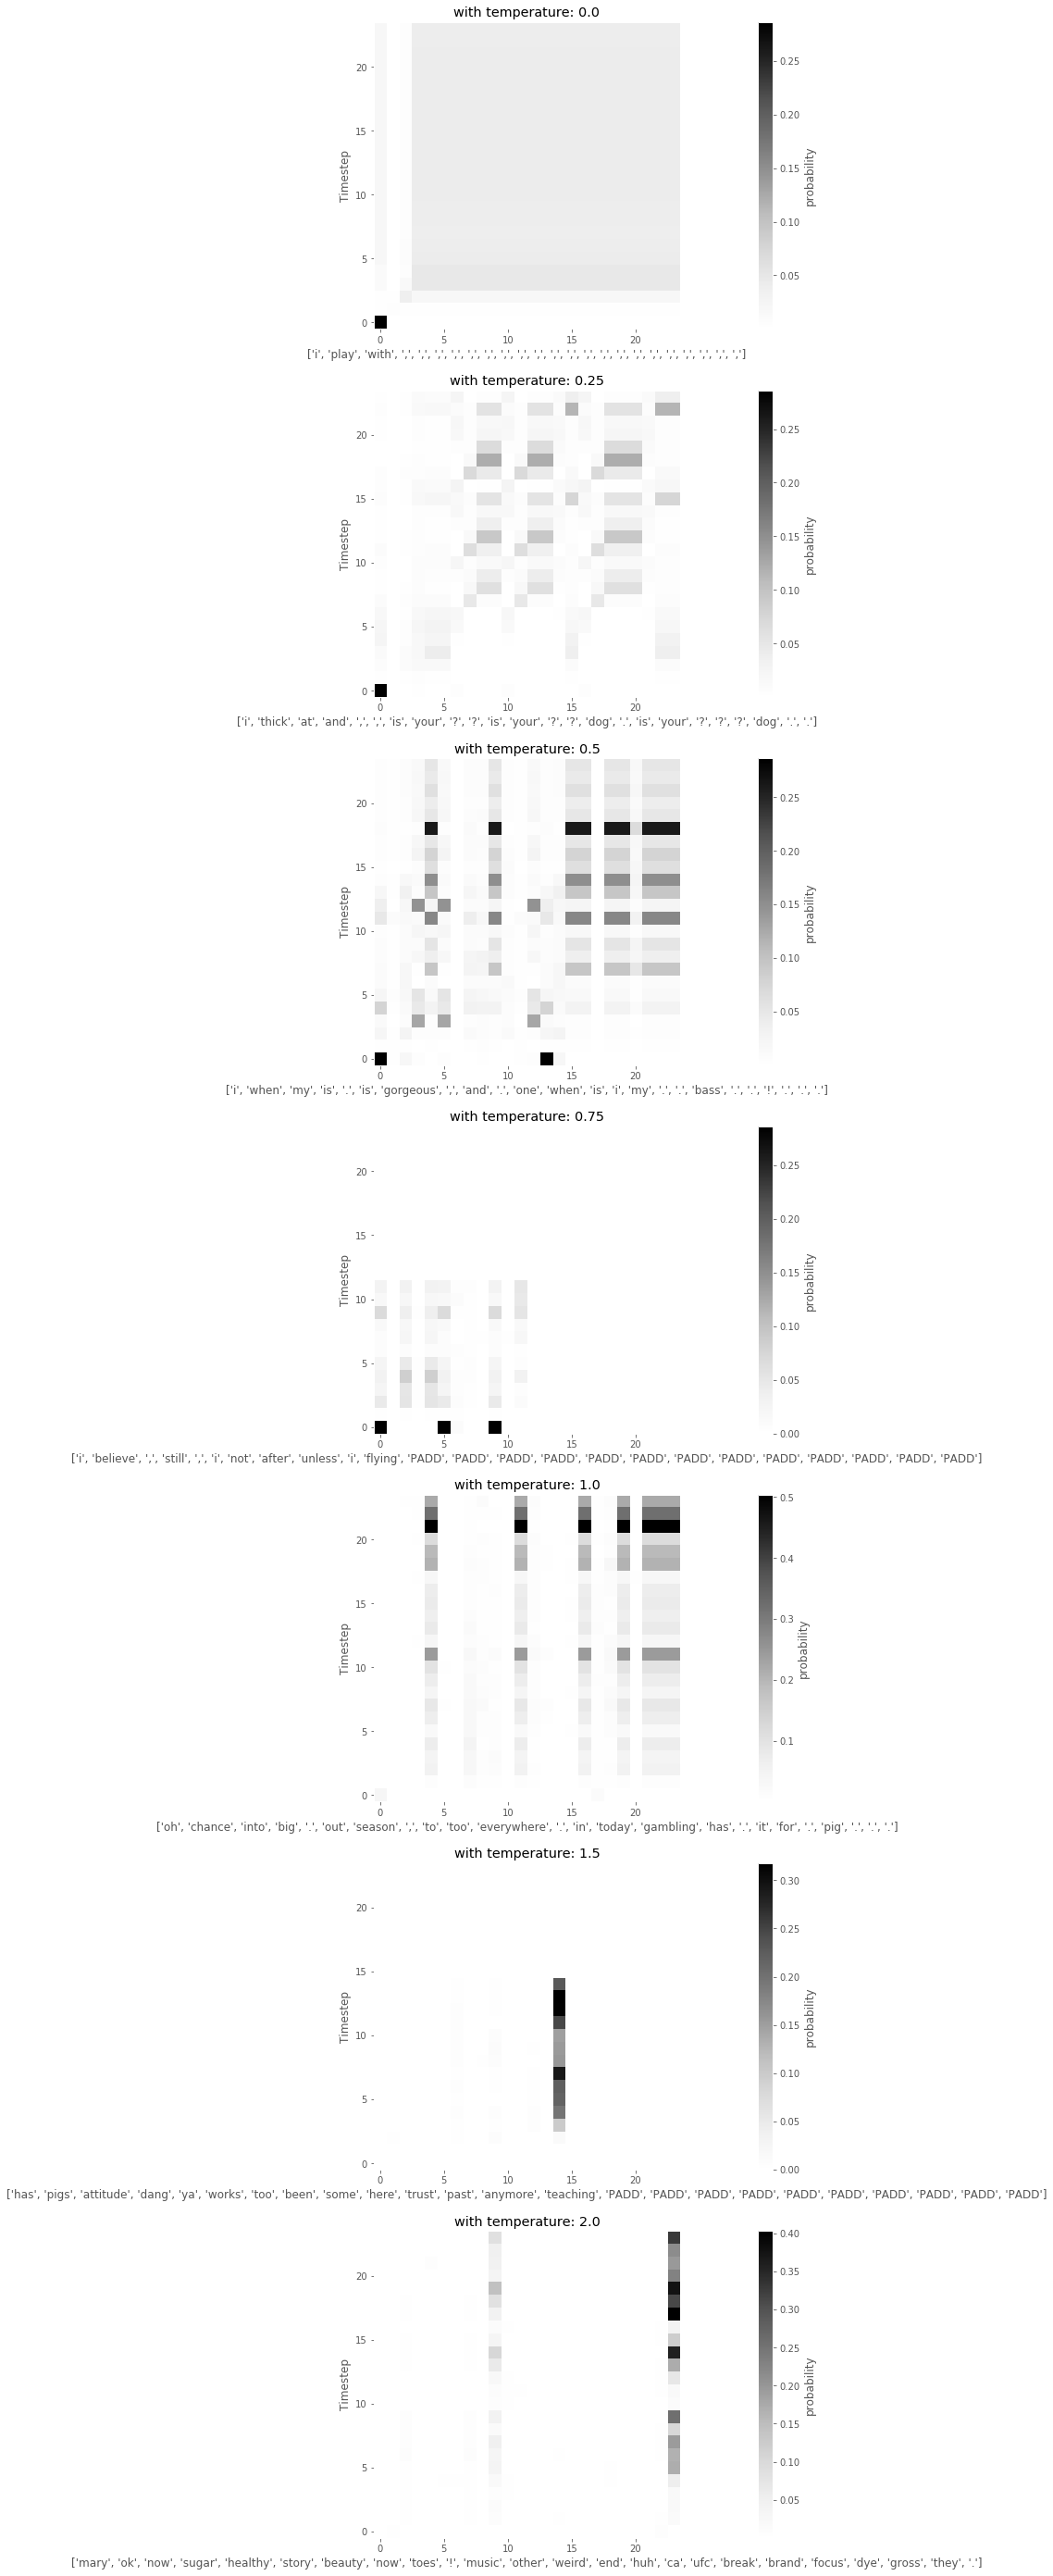

In [10]:
temperature = [0., 0.25, 0.5, 0.75, 1., 1.5, 2.]
f, ax = plt.subplots(7,1, figsize=(30,50))
for j,t in enumerate(temperature):
    
    base_sentence =["START", "PADD", "PADD", "PADD", "PADD", "PADD", "PADD", "PADD", "PADD", "PADD",
                     "PADD", "PADD", "PADD", "PADD", "PADD", "PADD", "PADD", "PADD", "PADD", "PADD",
                     "PADD", "PADD", "PADD", "PADD"]

    reverse_tokens = {v:k for k,v in tokens.items()}
    proba_matrix = np.zeros((24,2969))
    old_token = np.zeros(24, dtype=int)

    for i in range(len(base_sentence)):
        
        
        trans_sentence = np.array(translate(base_sentence,tokens,True))
        pred_prob = best_model.predict(trans_sentence.reshape(1,-1))

        w_token = sample(pred_prob[0][i], temperature=t)
        
        old_token[i] = w_token
        
        proba_matrix[i,:] = pred_prob[0][i]

        word = reverse_tokens[w_token]
        if word == "STOP":
            break
        else:
            base_sentence[i] = word
    #print(base_sentence)
    im = ax[j].imshow(proba_matrix[:,old_token], cmap="Greys")
    ax[j].set_xlabel(base_sentence)
    ax[j].set_ylabel("Timestep")
    ax[j].invert_yaxis()
    ax[j].set_title("with temperature: {t}".format(t=t))
    f.colorbar(im, ax=ax[j], label="probability")  

In [30]:
base_sentence1 =["he", "often", "plays", "tennis", "PADD", "PADD", "PADD", "PADD", "PADD", "PADD",
                     "PADD", "PADD", "PADD", "PADD", "PADD", "PADD", "PADD", "PADD", "PADD", "PADD",
                     "PADD", "PADD", "PADD", "PADD"]
    
base_sentence2 =["we", "walked", "the", "dog", "PADD", "PADD", "PADD", "PADD", "PADD", "PADD",
                     "PADD", "PADD", "PADD", "PADD", "PADD", "PADD", "PADD", "PADD", "PADD", "PADD",
                     "PADD", "PADD", "PADD", "PADD"]

sentences = [base_sentence1, base_sentence2]

reverse_tokens = {v:k for k,v in tokens.items()}

n_continuation = 10

for j,s in enumerate(sentences):
    for n in range(n_continuation):
        for i in range(4,len(sentences[j])):

            trans_sentence = np.array(translate(sentences[j],tokens,True))
            pred_prob = best_model.predict(trans_sentence.reshape(1,-1))
            w_token = sample(pred_prob[0][i], temperature=1.)
            word = reverse_tokens[w_token]

            if word == "STOP":
                break
            else:
                sentences[j][i] = word

        print(sentences[j])

['he', 'often', 'plays', 'tennis', 'near', 'me', 'stuff', 'food', '.', 'novels', 'most', 'myself', 'PADD', 'PADD', 'PADD', 'PADD', 'PADD', 'PADD', 'PADD', 'PADD', 'PADD', 'PADD', 'PADD', 'PADD']
['he', 'often', 'plays', 'tennis', 'me', ',', 'are', 'great', 'i', 'to', 'maybe', '.', 'business', 'acting', '.', 'business', '.', 'rest', '!', 'night', 'PADD', 'PADD', 'PADD', 'PADD']
['he', 'often', 'plays', 'tennis', 'to', 'in', 'people', 'mexico', 'am', 'graduate', 'maybe', '.', 'business', 'acting', '.', 'business', '.', 'rest', '!', 'night', 'PADD', 'PADD', 'PADD', 'PADD']
['he', 'often', 'plays', 'tennis', 'the', 'my', 'are', 'right', 'all', 'i', 'and', '.', 'business', 'acting', '.', 'business', '.', 'rest', '!', 'night', 'PADD', 'PADD', 'PADD', 'PADD']
['he', 'often', 'plays', 'tennis', 'most', 'photos', 'ten', 'now', 'those', 'do', 'do', '.', 'business', 'acting', '.', 'business', '.', 'rest', '!', 'night', 'PADD', 'PADD', 'PADD', 'PADD']
['he', 'often', 'plays', 'tennis', 'than', 'th

###  Word embedding visualization

Here, you are asked to visualize the embedding layer. 

**Code** To do that, project in 2D the embedding vectors for different words. Use t-SNE, a projection that conserve the neighborhood relationships between vectors. HINT: Build a Keras model that takes as input a list of words and outputs a list of vector embeddings as learned by your best performing model. Use t-SNE dimensionality reduction (from sklearn.manifold import TSNE). [2 pts]

**Figure** Plot the projection of the first 200 most frequent words in a 2D plot. On the plot, write the words. [2 pt] **see below**

**Question** Do you observe clusters of words with similar meaning or role in language? Report three of them here. [1 pt]

**Answer**: **Yes, see the plot below. 4 clusters highlighted with different Circles color. // (like,love,enjoy) // (nice,cool,awesome,great) // (does, do, did) // (can,could,should,would)**

**Question** Why is having similar vector representation for similar words a good approach for such models? Explain using the example clusters from before and argue in terms of prediction accuracy and/or generalization. [2 pts]

**Answer**: **Having similar vector representation for similar words is good because when generating sentences

In [64]:
most_freq_words = [w for w,freq in sorted_list[:200]]
idx_most_freq = [tokens[i] for i in most_freq_words]

In [39]:
from sklearn.manifold import TSNE

In [66]:
tsne_embedded = TSNE(n_components=2).fit_transform(lstm_embedding[idx_most_freq])

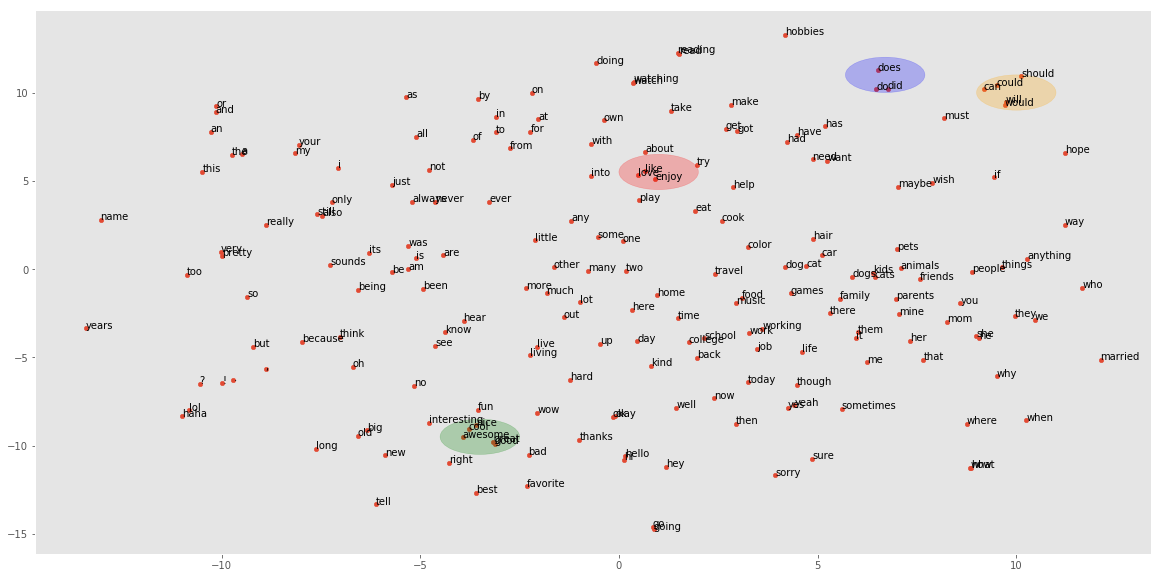

In [84]:
plt.figure(figsize = (20,10))
ax = plt.gca()
ax.scatter(tsne_embedded[:,0],tsne_embedded[:,1], s=20)

for i, txt in enumerate(most_freq_words):
    ax.annotate(txt, (tsne_embedded[i]))
    
condi_circle = plt.Circle((10,10),1,alpha=0.25, color="orange")
do_circle = plt.Circle((6.7,11),1,alpha=0.25, color="blue")
like_circle = plt.Circle((1,5.5), 1,alpha=0.25, color="red")
great_circle = plt.Circle((-3.5,-9.5), 1,alpha=0.25, color="green")

ax.add_artist(condi_circle)
ax.add_artist(do_circle)
ax.add_artist(like_circle)
ax.add_artist(great_circle)
plt.show()

## Chatbot

Finally, you will construct a model with which you can chat. The network will take as input a sentence and output a response.

**Code** For that, you should go back to your original data and construct a new dataset containing pairs of sentences, where each pair is a sentence and its answer. Be careful to not include any pair of sentences that contains words not present in your filtered dictionary. [2 pts]

**Code** You should then tokenize, padd, truncate each sentence. Only the answers need the 'START' and 'END' artificial words. [1 pt]

We provide you with a possible model, you are welcome to change it. This model uses an LSTM layer to encode the first sentence (the context). The final state of this LSTM layer is transfered to initialize the state of a decoder LSTM layer from which the answer sentence will be generated. 

**Code** Train your chatbot model on your dataset. [1 pt]

**Code** Adapt your sentence generation code from before so that you can generate an answer given a context sentence from your model. [2 pts] 

**Code** After training, randomly select 10 context-answers pairs from your data and show both the real answer (the one from the data) and the generated one for two different sampling temperatures (e.g. 0.5 and 1.0). [2 pts]

**Question** How similar are the generated answers and the real ones? Does your model provide probable answers (given the dataset)? Report here one good and one bad example. [2 pts]

**Answer**

**Question** Which sampling temperature gives better answers? why? [2 pts]

**Answer**

**Question** Would it be good if your model was able to reproduce exactly each real answer? Why? [1 pt]

**Answer**

**Code** Entertain yourself with your model. Write some code to chat with your bot, let it discuss with itself, ... be creative! [2 **bonus** pts]




In [43]:
X = []
T = []

for i,c in enumerate(norare_conv):

    for j,s in enumerate(c):

        if j == (len(c)-1):
            break
        else:
            X.append(s)
            T.append(norare_conv[i][j+1])

In [50]:
#Translate sentences to list of integers
trans_X = []
trans_T = []

for s_x, s_t in zip(X,T):
        
    words_x = s_x.split(" ")
    words_t = s_t.split(" ")
    new_s_x = translate(words_x,tokens,to_token=True)
    new_s_t = translate(words_t,tokens,to_token=True)

    # Add to every sentences of target(answer) START and STOP tokens
    new_s_t = [tokens["START"]] + new_s_t
    new_s_t.append(tokens["STOP"])
    trans_X.append(new_s_x)
    trans_T.append(new_s_t)

In [53]:
#padded too maxlen 25
maxlen = 25
padded_X = pad_sequences(trans_X, maxlen = maxlen, dtype = "uint32", padding = "post", truncating = "post", value = 0)
padded_T = pad_sequences(trans_T, maxlen = maxlen, dtype = "uint32", padding = "post", truncating = "post", value = 0)

In [55]:
#reshape dataset and target for RNN
X = np.array(padded_X)

#one hot encoding of X for target T
T = keras.utils.to_categorical(padded_T)

In [62]:
context = Input(shape=(maxlen-2,), name="input_context")
shared_embedding = LSTM.layers[1]
context_embedding = shared_embedding(context)

encoder_y, encoder_h, encoder_c = LSTM(hidden_size, 
            return_sequences=False,
            return_state=True,
            stateful=False,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            go_backwards=True,
            name="encoder")(context_embedding)

answer = Input(shape=(maxlen-1,), name="input_answer")
answer_embedding = shared_embedding(answer)

decoder_input = answer_embedding
decoder = LSTM(hidden_size, 
            return_sequences=True,
            stateful=False,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            name="decoder")(answer_embedding, initial_state=[encoder_h, encoder_c])
# decoder2 = LSTM(hidden_size, 
#             return_sequences=True,
#             stateful=False,
#             dropout=dropout,
#             recurrent_dropout=recurrent_dropout,
#             name="decoder2")(decoder)

R = TimeDistributed(Dense(embedding_size, activation='relu'), name='readout')(decoder)
Y = TimeDistributed(Dense(len(tokens), activation='softmax'), name='output')(R)

Chatbot = Model(inputs = [context, answer], outputs = [Y])
Chatbot.compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(),
    metrics=['acc'])
Chatbot.summary()


ValueError: Layer model_2 was called with an input that isn't a symbolic tensor. Received type: <class 'int'>. Full input: [64]. All inputs to the layer should be tensors.

In [ ]:
logs["Chatbot"] = Chatbot.fit({'input': [X[:dataset_cut,:-2],padded_T[:dataset_cut,:-2]]}, {'output': T[:dataset_cut,1:]}, 
                                    epochs=epochs, 
                                    validation_split=validation_split, 
                                    batch_size=batch_size,
                                    callbacks = [callback]).history

with open("Chatbot_log.pkl", "wb") as file:
    pickle.dump(logs['Chatbot'], file)
Chatbot.save("Chatbot")